In [59]:
from flv_utils import get_h5_by_name, by_class
import flv_utils as flv
from flv_utils import Path
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import os
import h5py
import numpy as np

mpl.rcParams.update({
    "font.family": "Liberation Mono",  # or "DejaVu Serif", "Liberation Sans", etc.
})

In [60]:
h5 = get_h5_by_name("2022-07-27-31")
ava = by_class("AVA")

In [61]:

def load_labeled_traces_from_dataset(dataset, confidence_threshold=0.5):
    """Load labeled traces from a dataset.
    
    Args:
        dataset (str): The name of the dataset to load.
        confidence_threshold (float): The confidence threshold for including neuron classes.
    
    Returns:
        unnormalized_traces (np.ndarray): The unnormalized traces from the dataset.
        neuron_class_to_idx (dict): A mapping from neuron class names to their corresponding indices.
        idx_to_neuron_class (dict): A mapping from indices to their corresponding neuron class names.
    """
    dataset_path = flv.get_dataset_h5_path(dataset)

    h5_data = flv.get_h5_by_name(dataset_path)

    path_to_dataset = flv.get_dataset_h5_path(dataset)
    path_to_project = Path(path_to_dataset).parent.parent
    project_label_paths = glob.glob(str(path_to_project / "labels_csv/*"))
    dataset_label_path = [p for p in project_label_paths if dataset in p][0]

    structured_data_path = path_to_project / "structured_data.csv"

    if structured_data_path is not None and os.path.exists(structured_data_path):
        structured_df = pd.read_csv(structured_data_path)
        flipped = structured_df[structured_df["Dataset"] == dataset]["Flipped"].iloc[0]
    else:
        flipped = False

    print(f"This dataset is {'flipped' if flipped else 'not flipped'}")

    unnormalized_traces = h5_data["gcamp"]["trace_array_original"].T

    neuron_class_to_idx = {}
    idx_to_neuron_class = {}

    if dataset_label_path is not None:
        try:
            if dataset_label_path.endswith(".xlsx"):
                # Read the Excel file into a DataFrame
                with open(dataset_label_path, "rb") as f:
                    df = flv.load_excel_file(f)
            else:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(dataset_label_path)
        except Exception as e:
            raise ValueError(f"Error reading labels file: {e}")

        neuron_classes = list(df["Neuron Class"])
        roi_ids = list(df["ROI ID"])
        confidences = list(df["Confidence"])
        for neuron_class, roi_id, confidence in zip(
            neuron_classes, roi_ids, confidences
        ):
            roi_id = int(float(str(roi_id).split("/")[0]))
            if confidence < confidence_threshold:
                continue
            neuron_class_to_idx[neuron_class] = int(
                h5_data["neuropal_registration"]["roi_match"][roi_id - 1] - 1
            )

        idx_to_neuron_class = {v: k for k, v in neuron_class_to_idx.items() if v != -1}

    for i in range(unnormalized_traces.shape[0]):
        idx_to_neuron_class[i] = idx_to_neuron_class.get(i, f"Neuron_{i:03d}")


    return unnormalized_traces, neuron_class_to_idx, idx_to_neuron_class

# dataset = '2022-07-27-31'
dataset = '2023-01-06-01'
unnormalized_traces, neuron_class_to_idx, idx_to_neuron_class = load_labeled_traces_from_dataset(dataset, confidence_threshold=0.5)

This dataset is flipped


In [62]:
neuron_class_to_idx['I1L']

97

In [63]:
corr_confs = np.loadtxt('correct_confs_testing.txt')
incorr_confs = np.loadtxt('incorrect_confs_testing.txt')

In [64]:
with h5py.File("/data3/adam/new_unet_train/extracted_neuron_ids_final_1.h5", "r") as f:
    neuron_ids = [name.decode('utf-8') for name in f['neuron_ids'][:]]

while True: # So I can run this while it's actively predicting (it'll wait for the lock to be released)
    try:
        with h5py.File("/home/brian/data4/brian/freelyMoving/data/ACLL_unsheared/NRRD_raw_test/liveTraces_mergeshear_bgsubtract.h5", "r") as f:
            live_traces = f["signal"][:]
            break

    except BlockingIOError:
        pass
neuron_ids = neuron_ids[:100] # Limit to 100 for plotting purposes

axes = plt.subplots(len(neuron_ids), 2, figsize=(20, 5 * len(neuron_ids)))[1]
for i, neuron in enumerate(neuron_ids):
    # print(neuron)
    if neuron not in neuron_class_to_idx:
        print(f"Skipping {neuron}")
        continue
    axes[i,0].plot(unnormalized_traces[neuron_class_to_idx[neuron]]) # We're working with neuron names, Adam's order IDs (both with bg and without), and CePNEM order IDs. This is for CePNEM
    axes[i,0].plot(live_traces[i+1]) # This has bg as 0 so we have to increment by one
    # axes[i].plot(live_traces_chan[i+1])
    axes[i,0].set_title(neuron)

    neur_corr = corr_confs[i]
    neur_incorr = incorr_confs[i]
    axes[i, 1].scatter(np.arange(corr_confs.shape[1]), neur_corr, c="tab:green", s=4)
    axes[i, 1].scatter(np.arange(corr_confs.shape[1]), neur_incorr, c="tab:red", s=4)
    axes[i, 1].set_ylim((0,1))
    axes[i, 1].set_xticks([])
    axes[i, 1].set_title(neuron)
    axes[i, 1].axvspan(100, 200, color='grey', alpha=0.1) 

plt.show()

### NOTE: X-axis are not on same scale at all. Can't compare betwen. Right is just for vague sense of neuron correctness

Skipping I2R
Skipping NSMR
Skipping MCR
Skipping IL2VR
Skipping URAVR
Skipping OLQVR
Skipping BAGL
Skipping RIPR
Skipping URBR
Skipping URYDL
Skipping RMEV
Skipping RIAL
Skipping SAAVR
Skipping AIBR
Skipping AWBR
Skipping ASGL
Skipping ASER
Skipping AVJR
Skipping RIVR
Skipping AINR
Skipping AVBL
Skipping AUAR
Skipping RICR
Skipping M1
Skipping RIS
Skipping SMDDR
Skipping AIYL
Skipping AIYR


(1615,)
(1615,)
(1615,)
(1615,)
(1615,)
(1615,)
(1615,)
(1615,)
(1615,)


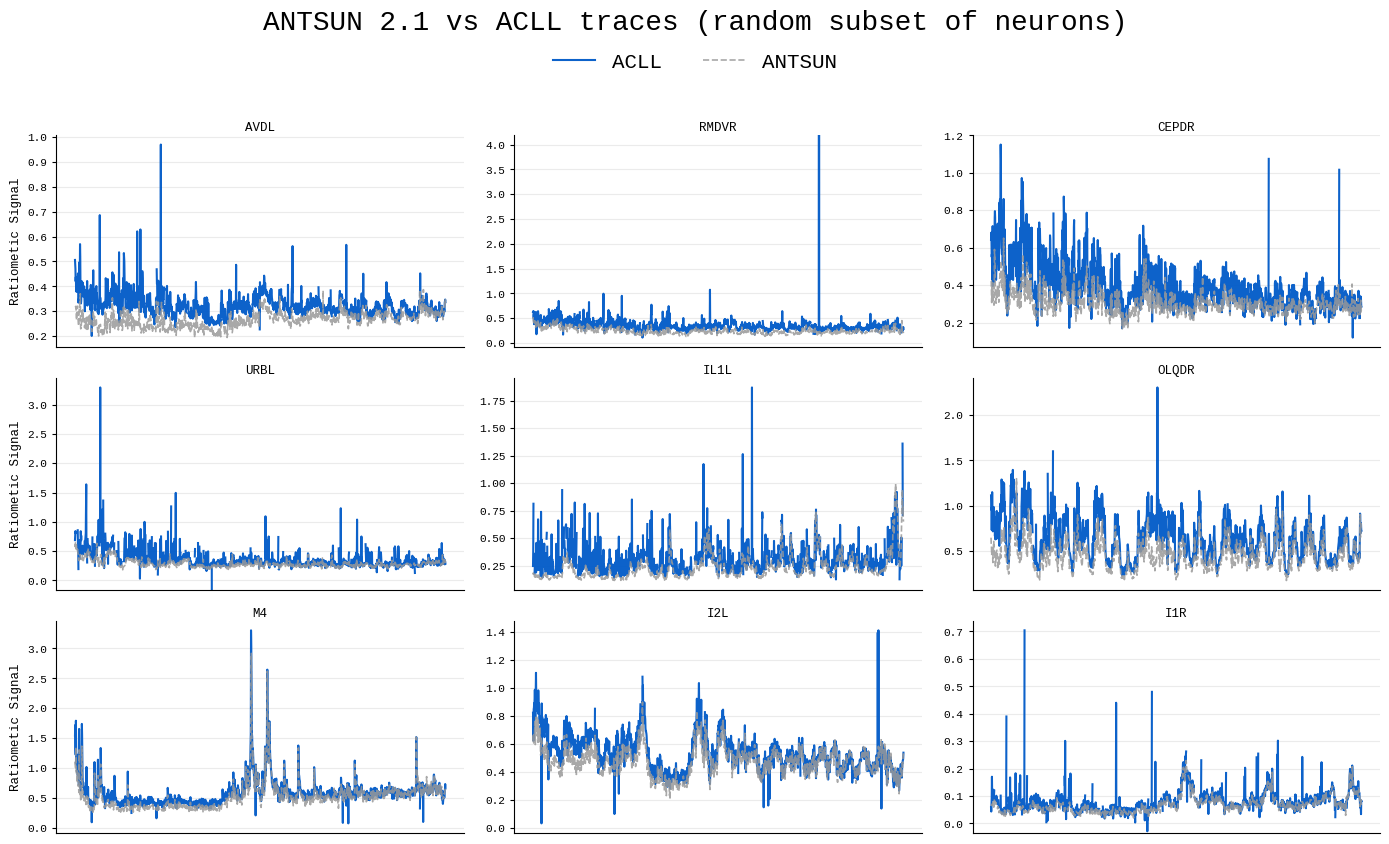

In [ ]:
%matplotlib inline
# choose a small subset to show in README
rng = np.random.default_rng(0)
neurons_to_show = rng.choice([neuron for neuron in neuron_ids if neuron in neuron_class_to_idx], size=9, replace=False)

n_show = len(neurons_to_show)
n_cols = 3
n_rows = int(np.ceil(n_show / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8), sharex=True)
axes = axes.ravel()

for ax_idx, (ax, neuron) in enumerate(zip(axes, neurons_to_show)):

    old_trace = np.asarray(unnormalized_traces[neuron_class_to_idx[neuron]])
    # live_traces[0] is background so offset index by 1
    i = neuron_ids.index(neuron)
    new_trace = np.asarray(live_traces[i + 1])

    # combine for per-neuron y-scaling with padding
    both = np.concatenate([old_trace, new_trace])
    both = both[~np.isnan(both)] 
    y_min, y_max = np.nanmin(both), np.nanmax(both)
    y_max = min(y_max, 4)
    y_min = max(y_min, 0)
    # y_min, y_max = np.quantile(both, 0.01), np.quantile(both, 0.99)
    if y_max == y_min:
        pad = 1.0
    else:
        pad = 0.05 * (y_max - y_min)
    ax.set_ylim(y_min - pad, y_max + pad)

    # clean plotting style: old = gray dashed, new = solid blue
    # only label the first axis for the legend
    ax.plot(
        new_trace,
        alpha=0.95,
        lw=1.5,
        color="#005ac8",
        label="ACLL" if ax_idx == 0 else None,
    )
    ax.plot(
        old_trace,
        alpha=0.85,
        lw=1.2,
        color="#999999",
        linestyle="--",
        label="ANTSUN" if ax_idx == 0 else None,
    )

    ax.set_title(str(neuron), fontsize=9, pad=3)

    # subtle grid + cleaner spines
    ax.grid(True, axis="y", alpha=0.25)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.tick_params(labelsize=8, length=3)

# hide unused axes if any
for ax in axes[n_show:]:
    ax.set_visible(False)

# label outer axes only to avoid clutter
for ax in axes:  # all but last row
    ax.set_xticklabels([])
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False)

for row_start in range(0, n_show, n_cols):
    axes[row_start].set_ylabel("Ratiometic Signal", fontsize=9)

# single legend at top
handles, labels = [], []
for h, l in zip(*axes[0].get_legend_handles_labels()):
    if l and l not in labels:
        handles.append(h)
        labels.append(l)

fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=2,
    frameon=False,
    fontsize=15,
    bbox_to_anchor=(0.5, 1.02),
)

fig.suptitle("ANTSUN 2.1 vs ACLL traces (random subset of neurons)", fontsize=20, y=1.05, fontfamily="Liberation Mono")
fig.tight_layout(rect=[0, 0, 1, 0.98])

plt.savefig("visualizations/trace_comparison_grid.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)


## Visualize Speedup

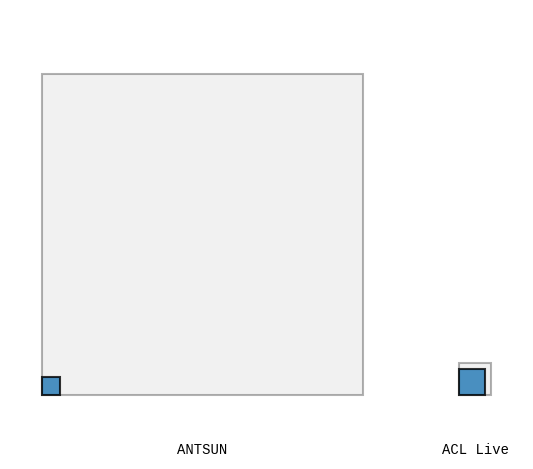

In [77]:
#!/usr/bin/env python3
"""
Visualize two pipelines as squares.

Each pipeline is a square:
- The square's area represents total runtime.
- A smaller inner square represents the runtime of a particular section.

The side lengths are chosen so that:
    area2 / area1 = total_ratio
and
    section_area_i / total_area_i = sub_ratio_i

So:
    side2 = side1 * (total_ratio) ** (1/2)
    inner_side_i = side_i * (sub_ratio_i) ** (1/2)

Example:
    # Pipeline 2 is half the runtime of pipeline 1,
    # section is 30% of pipeline 1 and 60% of pipeline 2:
    python squares_pipelines.py --total-ratio 0.5 --sub1 0.3 --sub2 0.6
"""

import argparse
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


total_ratio= 16 / (27 * 60)
sub_ratio1= 5 / (27 * 60)
sub_ratio2= .8 / 1.2
label1="ANTSUN"
label2="ACL Live"
   
# Outer squares: side1 = 1, derive side2 from area ratio
L1 = 1.0
L2 = math.sqrt(total_ratio)

# Gap between squares
maxL = max(L1, L2)
gap = 0.3 * maxL

# Bottom-left corners of the squares
origin1 = (0.0, 0.0)
origin2 = (L1 + gap, 0.0)

fig, ax = plt.subplots()

# --- Square 1 outer ---
outer1 = Rectangle(origin1, L1, L1,
                    linewidth=1.5, edgecolor="black",
                    facecolor="lightgray", alpha=0.3)
ax.add_patch(outer1)

# --- Square 1 inner (section) ---
s1 = L1 * math.sqrt(sub_ratio1)
inner1 = Rectangle(origin1, s1, s1,
                    linewidth=1.5, edgecolor="black",
                    facecolor="tab:blue", alpha=0.8)
ax.add_patch(inner1)

# --- Square 2 outer ---
outer2 = Rectangle(origin2, L2, L2,
                    linewidth=1.5, edgecolor="black",
                    facecolor="lightgray", alpha=0.3)
ax.add_patch(outer2)

# --- Square 2 inner (section) ---
s2 = L2 * math.sqrt(sub_ratio2)
inner2 = Rectangle(origin2, s2, s2,
                    linewidth=1.5, edgecolor="black",
                    facecolor="tab:blue", alpha=0.8)
ax.add_patch(inner2)

# Limits and aspect
xmin = 0.0
xmax = origin2[0] + L2
ymin = 0.0
ymax = maxL

ax.set_xlim(xmin - 0.1 * maxL, xmax + 0.1 * maxL)
ax.set_ylim(ymin - 0.2 * maxL, ymax + 0.2 * maxL)
ax.set_aspect("equal", adjustable="box")

# Labels under each square
ax.text(origin1[0] + L1 / 2, ymin - 0.15 * maxL, label1,
        ha="center", va="top")
ax.text(origin2[0] + L2 / 2, ymin - 0.15 * maxL, label2,
        ha="center", va="top")

ax.axis("off")
plt.tight_layout()
plt.savefig("visualizations/speedup_comparison.png", dpi=200, bbox_inches="tight")
plt.show()


